In [16]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [17]:
overviews=pd.read_csv("MoviesWithOverviews.csv")

In [19]:
print(overviews.shape)

(5039, 21)


In [20]:
#reference-https://stackabuse.com/python-for-nlp-multi-label-text-classification-with-keras/

In [21]:
#filter = overviews["overview"] != ""
#overviews = overviews[filter]
#overviews = overviews.dropna()

In [22]:
# Text cleaning
#reference: https://www.analyticsvidhya.com/blog/2019/04/predicting-movie-genres-nlp-multi-label-classification/

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text): 
    #removing everything except letters and converting to lower case
    text = re.sub("[^a-zA-Z]"," ",str(text))
    text = ' '.join(text.split())
    text = text.lower() 
    return text

# Removing stopwords such as the, and, to, or etc
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

In [23]:
plot_summaries=[]
for text in overviews['overview']:
    cleanText=clean_text(text)
    textWithoutStopwords=remove_stopwords(cleanText)
    plot_summaries+=[textWithoutStopwords]
overviews.insert(1,"clean_overview", plot_summaries, True)
print("Features: ", overviews.columns)

Features:  Index(['overview', 'clean_overview', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
       'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western'],
      dtype='object')


In [27]:
genreLabels=overviews[[ 'Action', 'Adventure', 'Animation', 
       'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign',
       'History', 'Horror', 'Music',
       'Mystery', 
       'Romance', 'Science Fiction', 'TV Movie',
        'Thriller',
        'War', 'Western']]
genreLabels.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

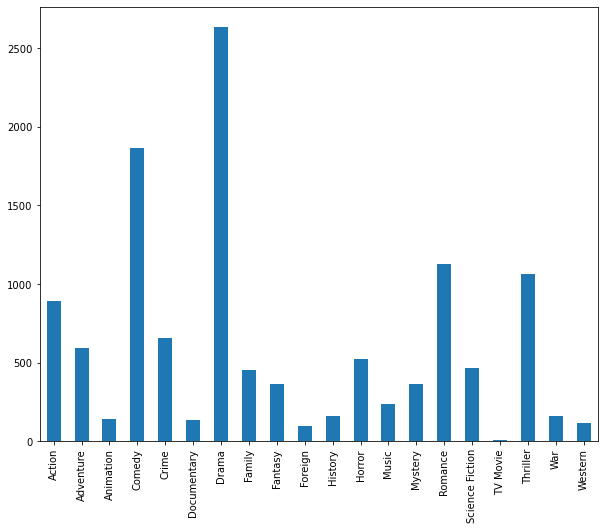

In [28]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
genreLabels.sum(axis=0).plot.bar()

In [29]:
X = []
sentences = list(overviews["clean_overview"])
for sen in sentences:
    X.append(sen)

y = genreLabels.values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
#number of unique words
vocab_length = len(tokenizer.word_index) + 1

In [15]:
#converting sentences to arrays
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [17]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/harshikajalan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
#Finding the number of words in the longest overveiw and applying padding
from nltk.tokenize import word_tokenize

word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(overviews["clean_overview"], key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))
print(length_long_sentence )

X_train = pad_sequences(X_train, length_long_sentence, padding='post')
X_test = pad_sequences(X_test, length_long_sentence, padding='post')


177


In [23]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/Users/harshikajalan/Downloads/glove.6B/glove.6B.100d.txt', encoding="utf8")#change path

In [24]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [25]:
#creating embedding matrix
embedding_matrix = zeros((vocab_length, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [27]:
deep_inputs = Input(shape=(length_long_sentence,))
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(32, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [28]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 177)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 177, 100)          6595900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
Total params: 6,717,276
Trainable params: 121,376
Non-trainable params: 6,595,900
_________________________________________________________________
None


In [29]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)


Train on 28487 samples, validate on 7122 samples
Epoch 1/5
28487/28487 [==============================] - 53s 2ms/step - loss: 0.2067 - acc: 0.9350 - val_loss: 0.1756 - val_acc: 0.9375
Epoch 2/5
28487/28487 [==============================] - 51s 2ms/step - loss: 0.1779 - acc: 0.9363 - val_loss: 0.1751 - val_acc: 0.9376
Epoch 3/5
28487/28487 [==============================] - 50s 2ms/step - loss: 0.1778 - acc: 0.9365 - val_loss: 0.1753 - val_acc: 0.9376
Epoch 4/5
28487/28487 [==============================] - 52s 2ms/step - loss: 0.1777 - acc: 0.9365 - val_loss: 0.1754 - val_acc: 0.9376
Epoch 5/5
28487/28487 [==============================] - 54s 2ms/step - loss: 0.1777 - acc: 0.9362 - val_loss: 0.1751 - val_acc: 0.9376
